# Exoplanet Prediction Model

Over a period of nine years in deep space, the NASA Kepler space telescope has been out on a planet-hunting mission to discover hidden planets outside of our solar system.

Below are several machine learning models capable of classifying candidate exoplanets from the raw dataset

Data from [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=koi)

In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /opt/anaconda3/envs/PythonAdv/lib/python3.6/site-packages (0.0)


In [2]:
# install joblib for saving
# Restart kernel after installing 
!pip install joblib

In [3]:
import pandas as pd

### Read the CSV and Perform Basic Data Cleaning

In [4]:
df = pd.read_csv("exoplanet_data.csv")

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()
df.columns

Index(['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co',
       'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2',
       'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact',
       'koi_impact_err1', 'koi_impact_err2', 'koi_duration',
       'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1',
       'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2',
       'koi_teq', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
       'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1',
       'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2',
       'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec',
       'koi_kepmag'],
      dtype='object')

## Exploring and Selecting the Data

This dataset is a cumulative record of all observed Kepler "objects of interest" and contains an extensive data directory. 

**Exoplanet Achive Information**: The disposition or label in the literature for the exoplanet candidate. One of CANDIDATE, FALSE POSITIVE, NOT DISPOSITIONED or CONFIRMED. (**koi_disposition**)

**Project Disposition Columns**: NASA flags used to identify or assign the foreign body. Labeled with _flag_ and not useful for generating a model.

**Transit Properties**: Calculated parameters of the object such as  Orbital Period, Transit Epoch, Planet-Star Radius Ratio, Planet-Star Distance over Star Radius and Impact Parameter. _Transit properties contain uncertainty values and are identified with a suffix _err. The margin of error is NOT included in the model_

**Stellar Parameters**: Stellar parameters are observational data used to determine stellar physics. These include effective temperature, surface gravity, metallicity, radius, mass, and ageCalculated parameters of the object such as  Orbital Period, Transit Epoch, Planet-Star Radius Ratio, Planet-Star Distance over Star Radius and Impact Parameter. _Stellar properties contain uncertainty values and are identified with a suffix _err. The margin of error is NOT included in the model_

**KIC Parameters**: Physical properties and target identifier.

[Full Directory of Data Columns Definitions](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)


In [5]:
# Removing unwanted columns from dataset
exo_df = df[['koi_period', 'koi_time0bk', 'koi_impact','koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol','koi_model_snr', 'koi_steff', 'koi_srad','ra', 'dec',
       'koi_kepmag']]
exo_df.head()

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_srad,ra,dec,koi_kepmag
0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443,9.11,25.8,5455,0.927,291.93423,48.141651,15.347
1,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638,39.30,76.3,5853,0.868,297.00482,48.134129,15.436
2,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395,891.96,505.6,5805,0.791,285.53461,48.285210,15.597
3,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406,926.16,40.9,6031,1.046,288.75488,48.226200,15.509
4,4.134435,172.979370,0.762,3.14020,686.0,2.77,1160,427.65,40.2,6046,0.972,296.28613,48.224670,15.714


In [6]:
# Find the classifiers for the koi_disposition
df["koi_disposition"].unique()

array(['CONFIRMED', 'FALSE POSITIVE', 'CANDIDATE'], dtype=object)

# Preprocessing the Data

### Assign X(features) and y (target) from the data

In [7]:
X = exo_df
y = df["koi_disposition"]
print(X.shape, y.shape)

(6991, 14) (6991,)


### Split the data into testing and training

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_steff,koi_srad,ra,dec,koi_kepmag
6122,6.768901,133.077240,0.150,3.61600,123.1,1.24,1017,253.30,10.8,5737,1.125,294.40472,39.351681,14.725
6370,0.733726,132.020050,0.291,2.30900,114.6,0.86,1867,2891.64,13.8,5855,0.797,284.50391,42.463860,15.770
2879,7.652707,134.460380,0.970,79.89690,641.1,3.21,989,226.81,254.3,6328,0.963,295.50211,38.983540,13.099
107,7.953547,174.662240,0.300,2.63120,875.4,2.25,696,55.37,38.4,4768,0.779,291.15878,40.750271,15.660
29,4.959319,172.258529,0.831,2.22739,9802.0,12.21,1103,349.40,696.5,5712,1.082,292.16705,48.727589,15.263


### MinMaxScalar to fit and transform X features

In [9]:
#Fit Transform using MinMaxScalar for X features
from sklearn.preprocessing import MinMaxScaler
X_minmax = MinMaxScaler().fit(X_train)

X_train_minmax = X_minmax.transform(X_train)
X_test_minmax = X_minmax.transform(X_test)

### Label Encoding for target (y) value

In [10]:
# Visualize Label Encoding
from sklearn.preprocessing import LabelEncoder
disposition_types = ('CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE')
disposition_df = pd.DataFrame(disposition_types, columns=['disposition_types'])# converting type of columns to 'category'

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
disposition_df['disposition_types_cat'] = labelencoder.fit_transform(disposition_df['disposition_types'])
disposition_df

,disposition_types,disposition_types_cat
0,CANDIDATE,0
1,CONFIRMED,1
2,FALSE POSITIVE,2


In [11]:
# Perform Label encoding on train and test data set for y
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

In [12]:
# Create one-hot encoding for neural network
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

# Algorithm #1: Support Vector Machine Linear Classifier

In [13]:
# Create the SVC Model
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train_minmax, y_train)

print(f"Training Data Score: {model.score(X_train_minmax, y_train)}")
print(f"Testing Data Score: {model.score(X_test_minmax, y_test)}")

Training Data Score: 0.6021361815754339
Testing Data Score: 0.5886727688787186


### Hypertune SVM using GridSearch CV

In [14]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, verbose=3)

In [15]:
# Fit the Model using the grid search estimator
grid.fit(X_train_minmax, encoded_y_train)
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... C=1, gamma=0.0001, score=0.591, total=   0.3s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ................... C=1, gamma=0.0001, score=0.595, total=   0.3s
[CV] C=1, gamma=0.0001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV] ................... C=1, gamma=0.0001, score=0.602, total=   0.3s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.590, total=   0.3s
[CV] C=1, gamma=0.0001 ...............................................
[CV] ................... C=1, gamma=0.0001, score=0.592, total=   0.3s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.591, total=   0.3s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.595, total=   0.3s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.602, total=   0.3s
[CV] C=1, gamma=0.0005 ...............................................
[CV] ................... C=1, gamma=0.0005, score=0.590, total=   0.3s
[CV] C=1, gamma=0.0005 ...............................................
[CV] .

[CV] .................. C=50, gamma=0.0001, score=0.662, total=   0.5s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.659, total=   0.5s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.632, total=   0.4s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.645, total=   0.4s
[CV] C=50, gamma=0.0001 ..............................................
[CV] .................. C=50, gamma=0.0001, score=0.657, total=   0.4s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .................. C=50, gamma=0.0005, score=0.662, total=   0.4s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .................. C=50, gamma=0.0005, score=0.659, total=   0.4s
[CV] C=50, gamma=0.0005 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   29.1s finished


{'C': 50, 'gamma': 0.0001}


In [16]:
print(f"Best Parameters: {grid.best_params_}")
print(f"Best SVG score: {grid.best_score_}")

Best Parameters: {'C': 50, 'gamma': 0.0001}
Best SVG score: 0.6509632947409019


### Create and Fit Hypertune SVM

In [17]:
model2 = SVC(C=50, gamma= 0.0001, kernel='linear')
model2.fit(X_train_minmax, encoded_y_train)
print(f"Training Data Score: {model2.score(X_train_minmax, encoded_y_train)}")
print(f"Testing Data Score: {model2.score(X_test_minmax, encoded_y_test)}")

Training Data Score: 0.6582109479305741
Testing Data Score: 0.6361556064073226


In [18]:
# Calculate classification report
predictions = grid.predict(X_test_minmax)

from sklearn.metrics import classification_report
print(classification_report(encoded_y_test, predictions, target_names = ["CANDIDATE", "CONFIRMED", "FALSE POSITIVE"]))

                precision    recall  f1-score   support

     CANDIDATE       0.41      0.32      0.36       411
     CONFIRMED       0.58      0.62      0.60       484
FALSE POSITIVE       0.75      0.80      0.77       853

      accuracy                           0.64      1748
     macro avg       0.58      0.58      0.58      1748
  weighted avg       0.62      0.64      0.63      1748



### Save the Model

In [19]:
# save your model by updating "your_name" with your name
# and "your_model" with your model variable
# be sure to turn this in to BCS
# if joblib fails to import, try running the command to install in terminal/git-bash
import joblib
filename = 'lmstein_svm.sav'
joblib.dump("lmstein", filename)

['lmstein_svm.sav']

# Algorithm #2: Random Forest 

In [20]:
from sklearn.ensemble import RandomForestClassifier

# STEP 1: Create a random forest classifier
rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train_minmax, encoded_y_train)
score = rf.score(X_test_minmax, encoded_y_test)

# STEP 2: Auto calculate feature importance
importances = rf.feature_importances_
importances

# Sort the features by their importance
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.14622887857630507, 'koi_model_snr'),
 (0.12125998399875587, 'koi_prad'),
 (0.08561620830463908, 'koi_period'),
 (0.08217510719616317, 'koi_depth'),
 (0.08202253754167232, 'koi_impact'),
 (0.07183193095837821, 'koi_duration'),
 (0.06608224898429445, 'koi_teq'),
 (0.05994798934376829, 'koi_time0bk'),
 (0.056318682599592634, 'koi_insol'),
 (0.04991418562129353, 'ra'),
 (0.048101686851028926, 'koi_steff'),
 (0.046292092421976384, 'koi_srad'),
 (0.042108861813543716, 'koi_kepmag'),
 (0.04209960578858843, 'dec')]

In [21]:
print(f"Random Forest Testing Score: {score}")

Random Forest Testing Score: 0.7494279176201373


### Save the Model

In [22]:
import joblib
filename = 'lmstein_rf.sav'
joblib.dump("lmstein", filename)

['lmstein_rf.sav']

# Algorithm #3: kNN Model

In [23]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# Identify optimal k value
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_minmax, y_train)
    train_score = knn.score(X_train_minmax, y_train)
    test_score = knn.score(X_test_minmax, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")

k: 1, Train/Test Score: 1.000/0.576
k: 3, Train/Test Score: 0.766/0.556
k: 5, Train/Test Score: 0.704/0.550
k: 7, Train/Test Score: 0.683/0.560
k: 9, Train/Test Score: 0.673/0.561
k: 11, Train/Test Score: 0.660/0.551
k: 13, Train/Test Score: 0.651/0.565
k: 15, Train/Test Score: 0.642/0.569
k: 17, Train/Test Score: 0.634/0.568
k: 19, Train/Test Score: 0.633/0.565


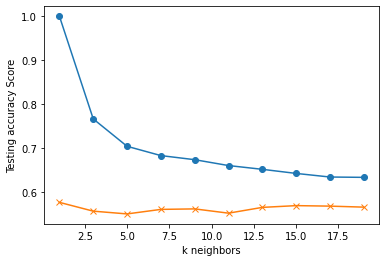

In [24]:
#Plot k values
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [25]:
# Use optimal k value to run kNN and score
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_minmax, y_train)
print('k=9 Test Acc: %.3f' % knn.score(X_test_minmax, y_test))

k=9 Test Acc: 0.561


### Save the Model

In [26]:
import joblib
filename = 'lmstein_knn.sav'
joblib.dump("lmstein", filename)

['lmstein_knn.sav']

# Algorithm #4: Logistic Regression

In [31]:
import matplotlib.pyplot as plt

#Create a logistic regression model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(max_iter=500)

# Fit the model to the data
classifier.fit(X_train_minmax, y_train)


# Scoer the model
print(f"Training Data Score: {classifier.score(X_train_minmax, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_minmax, y_test)}")

#Make predictions using the X_test and y_test data
predictions = classifier.predict(X_test_minmax)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

Training Data Score: 0.6006103375929811
Testing Data Score: 0.5892448512585813


,Prediction,Actual
4982,CONFIRMED,FALSE POSITIVE
4866,CANDIDATE,CANDIDATE
2934,FALSE POSITIVE,FALSE POSITIVE
5007,FALSE POSITIVE,FALSE POSITIVE
3869,FALSE POSITIVE,FALSE POSITIVE
...,...,...
4006,FALSE POSITIVE,CANDIDATE
6985,FALSE POSITIVE,CANDIDATE
1468,FALSE POSITIVE,CONFIRMED
5138,FALSE POSITIVE,CONFIRMED


In [32]:
import joblib
filename = 'lmstein_lr.sav'
joblib.dump("lmstein", filename)

['lmstein_lr.sav']